<a href="https://colab.research.google.com/github/petruha16/Complete-Python-3-Bootcamp/blob/master/drive_sign_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch --upgrade -q

In [ ]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 8.3MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 51.1MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
import fastai

In [ ]:
from fastai.vision.all import *

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

In [ ]:
import torch
#before training
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
path = Path.cwd()/'sign'

In [ ]:
csv = path/'Train.csv'
df = pd.read_csv(csv)

In [ ]:
meta = path/'Meta.csv'
df_meta = pd.read_csv(meta)

In [ ]:
keep = df.columns[-2:]
df = df[keep]

In [ ]:
df.ClassId.nunique()

43

In [ ]:
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.33)
for train_idx, valid_idx in split.split(df,df['ClassId']):
  strat_train_set = df.loc[train_idx]
  strat_valid_set = df.loc[valid_idx]

In [ ]:
strat_train_set['is_valid'] = False
strat_valid_set['is_valid'] = True

In [ ]:
df = pd.concat([strat_train_set,strat_valid_set], ignore_index=True).sort_values('ClassId')

In [ ]:
df.rename(columns={'ClassId':'label', 'Path':'image'},inplace=True)

In [ ]:
df['image'] = df['image'].apply(lambda x: x.split('/')[-1])

In [ ]:
images = path/'train'

In [ ]:
images.ls()

(#42) [Path('/content/sign/train/11'),Path('/content/sign/train/34'),Path('/content/sign/train/32'),Path('/content/sign/train/28'),Path('/content/sign/train/5'),Path('/content/sign/train/31'),Path('/content/sign/train/39'),Path('/content/sign/train/8'),Path('/content/sign/train/3'),Path('/content/sign/train/0')...]

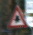

In [ ]:
im = PILImage.create(images.ls()[0].ls()[0])
im.to_thumb(360)

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [ ]:
tr_path = path/'train'
new_dir = path/'images'

In [ ]:
import shutil

for i in tr_path.iterdir():
    for k in i.iterdir():
      shutil.move(tr_path/i/k.name, new_dir/k.name)

In [ ]:
tr_path.ls()

(#42) [Path('/content/sign/train/11'),Path('/content/sign/train/34'),Path('/content/sign/train/32'),Path('/content/sign/train/28'),Path('/content/sign/train/5'),Path('/content/sign/train/31'),Path('/content/sign/train/39'),Path('/content/sign/train/8'),Path('/content/sign/train/3'),Path('/content/sign/train/0')...]

In [ ]:
new_dir.ls()

(#37709) [Path('/content/sign/images/00007_00006_00011.png'),Path('/content/sign/images/00035_00028_00003.png'),Path('/content/sign/images/00038_00034_00004.png'),Path('/content/sign/images/00004_00057_00017.png'),Path('/content/sign/images/00031_00003_00012.png'),Path('/content/sign/images/00029_00005_00018.png'),Path('/content/sign/images/00033_00007_00009.png'),Path('/content/sign/images/00028_00006_00026.png'),Path('/content/sign/images/00011_00037_00001.png'),Path('/content/sign/images/00004_00024_00012.png')...]

In [ ]:
new_df = df[df['label']!=25]

In [ ]:
new_df = new_df.reset_index()
new_df.drop('index',axis=1,inplace=True)

In [ ]:
new_df

,label,image,is_valid
0,0,00000_00000_00008.png,False
1,0,00000_00005_00018.png,False
2,0,00000_00002_00013.png,False
3,0,00000_00003_00026.png,False
4,0,00000_00001_00012.png,False
...,...,...,...
37704,42,00042_00005_00010.png,True
37705,42,00042_00005_00017.png,True
37706,42,00042_00005_00009.png,True
37707,42,00042_00000_00001.png,False


In [ ]:
def get_x(r): return new_dir/r['image']
def get_y(r): return r['label']

In [ ]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(256))

In [ ]:
dl = db.dataloaders(new_df)

In [ ]:
new_df

,label,image,is_valid
0,0,00000_00000_00008.png,False
1,0,00000_00005_00018.png,False
2,0,00000_00002_00013.png,False
3,0,00000_00003_00026.png,False
4,0,00000_00001_00012.png,False
...,...,...,...
37704,42,00042_00005_00010.png,True
37705,42,00042_00005_00017.png,True
37706,42,00042_00005_00009.png,True
37707,42,00042_00000_00001.png,False


In [ ]:
def get_test_x(r): return test/r['image']
def get_test_y(r): return r['label']

In [ ]:
test_db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_test_x,
                  get_y=get_test_y,
                   item_tfms=Resize(256))

test_dl = test_db.dataloaders(test_df)

In [ ]:
test_df

,label,Path,image
0,16,Test/00000.png,00000.png
1,1,Test/00001.png,00001.png
2,38,Test/00002.png,00002.png
3,33,Test/00003.png,00003.png
4,11,Test/00004.png,00004.png
...,...,...,...
12625,12,Test/12625.png,12625.png
12626,33,Test/12626.png,12626.png
12627,6,Test/12627.png,12627.png
12628,7,Test/12628.png,12628.png


In [ ]:
tdl = test_dl.test_dl(test_df)

In [ ]:
preds = learn.get_preds(dl=tdl)

In [ ]:
test_result = torch.argmax(preds[0],dim=1)
result = test_result.numpy()

In [ ]:
result

array([16,  1, 37, ..., 37, 37, 37])

In [ ]:
test_df['predicted'] = result
test_df

,label,Path,image,predicted,score,scoring
0,16,Test/00000.png,00000.png,16,1.000000,True
1,1,Test/00001.png,00001.png,1,1.000000,True
2,38,Test/00002.png,00002.png,37,0.973684,False
3,33,Test/00003.png,00003.png,32,0.969697,False
4,11,Test/00004.png,00004.png,20,1.818182,False
...,...,...,...,...,...,...
12625,12,Test/12625.png,12625.png,37,3.083333,False
12626,33,Test/12626.png,12626.png,32,0.969697,False
12627,6,Test/12627.png,12627.png,37,6.166667,False
12628,7,Test/12628.png,12628.png,37,5.285714,False


In [ ]:
test_df['score'] = test_df['predicted']/test_df['label']
test_df['scoring'] = test_df['score'].apply(lambda x: True if x == 1 else False)

In [ ]:
test_df

,label,Path,image,predicted,score,scoring
0,16,Test/00000.png,00000.png,16,1.000000,True
1,1,Test/00001.png,00001.png,1,1.000000,True
2,38,Test/00002.png,00002.png,37,0.973684,False
3,33,Test/00003.png,00003.png,32,0.969697,False
4,11,Test/00004.png,00004.png,20,1.818182,False
...,...,...,...,...,...,...
12625,12,Test/12625.png,12625.png,37,3.083333,False
12626,33,Test/12626.png,12626.png,32,0.969697,False
12627,6,Test/12627.png,12627.png,37,6.166667,False
12628,7,Test/12628.png,12628.png,37,5.285714,False


In [ ]:
test_df.scoring.value_counts()

False    8138
True     4492
Name: scoring, dtype: int64

In [ ]:
test_df.scoring.value_counts()

False    8130
True     4500
Name: scoring, dtype: int64

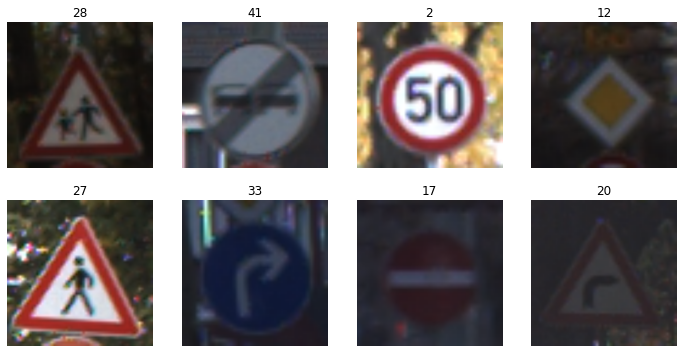

In [ ]:
dl.show_batch(nrows=2, ncols=4)

In [ ]:
learn = cnn_learner(dl, resnet34, metrics=[accuracy])
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.155220,2.535039,0.886612,01:45


epoch,train_loss,valid_loss,accuracy,time
0,0.523030,4.170826,0.976615,02:04


In [ ]:
learn.save('resnet34')

Path('models/resnet34.pth')

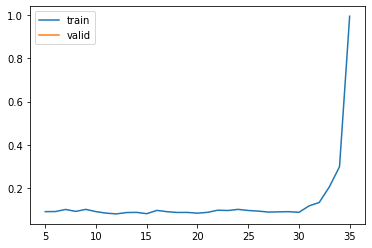

In [ ]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=2.75422871709452e-06)

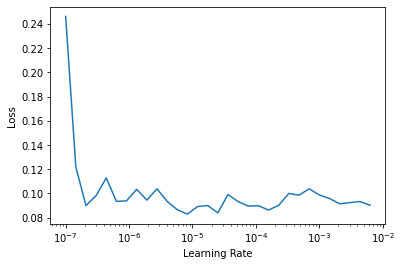

In [ ]:
learn.lr_find(num_it=50)

In [ ]:
path.ls()

(#11) [Path('/content/sign/Meta'),Path('/content/sign/Test.csv'),Path('/content/sign/meta'),Path('/content/sign/test'),Path('/content/sign/Meta.csv'),Path('/content/sign/images'),Path('/content/sign/Test'),Path('/content/sign/gtsrb-german-traffic-sign.zip'),Path('/content/sign/Train.csv'),Path('/content/sign/Train')...]

In [ ]:
test_csv = path/'Test.csv'
test_df = pd.read_csv(test_csv)

In [ ]:
test = path/'test'
test

Path('/content/sign/test')

In [ ]:
test.ls()

(#12631) [Path('/content/sign/test/07318.png'),Path('/content/sign/test/11698.png'),Path('/content/sign/test/09702.png'),Path('/content/sign/test/08951.png'),Path('/content/sign/test/08768.png'),Path('/content/sign/test/02424.png'),Path('/content/sign/test/04310.png'),Path('/content/sign/test/05154.png'),Path('/content/sign/test/06586.png'),Path('/content/sign/test/08809.png')...]

In [ ]:
test_df = test_df[keep]
test_df['image'] = test_df['Path'].apply(lambda x: x[5:])

In [ ]:
test_df.rename(columns={'ClassId':'label'},inplace=True)
test_df.head()

,label,Path,image
0,16,Test/00000.png,00000.png
1,1,Test/00001.png,00001.png
2,38,Test/00002.png,00002.png
3,33,Test/00003.png,00003.png
4,11,Test/00004.png,00004.png


In [ ]:
test_df

,label,Path,image
0,16,Test/00000.png,00000.png
1,1,Test/00001.png,00001.png
2,38,Test/00002.png,00002.png
3,33,Test/00003.png,00003.png
4,11,Test/00004.png,00004.png
...,...,...,...
12625,12,Test/12625.png,12625.png
12626,33,Test/12626.png,12626.png
12627,6,Test/12627.png,12627.png
12628,7,Test/12628.png,12628.png


In [ ]:
accuracy(preds, targs).item()

0.9771777391433716

In [ ]:
p.ls()

(#5) [Path('/root/.fastai/data/mnist_tiny/valid'),Path('/root/.fastai/data/mnist_tiny/test'),Path('/root/.fastai/data/mnist_tiny/labels.csv'),Path('/root/.fastai/data/mnist_tiny/models'),Path('/root/.fastai/data/mnist_tiny/train')]

In [ ]:
fnames = get_image_files(test)

In [ ]:
fnames

(#12630) [Path('/content/sign/test/07318.png'),Path('/content/sign/test/11698.png'),Path('/content/sign/test/09702.png'),Path('/content/sign/test/08951.png'),Path('/content/sign/test/08768.png'),Path('/content/sign/test/02424.png'),Path('/content/sign/test/04310.png'),Path('/content/sign/test/05154.png'),Path('/content/sign/test/06586.png'),Path('/content/sign/test/08809.png')...]

In [ ]:
from fastai.vision.data import ImageDataLoaders
def label_func(x): return x.parent.name
test_dls = ImageDataLoaders.from_path_func(test, fnames, label_func)

In [ ]:
test_dls

In [ ]:
test_df

,label,Path,image
0,16,Test/00000.png,00000.png
1,1,Test/00001.png,00001.png
2,38,Test/00002.png,00002.png
3,33,Test/00003.png,00003.png
4,11,Test/00004.png,00004.png
...,...,...,...
12625,12,Test/12625.png,12625.png
12626,33,Test/12626.png,12626.png
12627,6,Test/12627.png,12627.png
12628,7,Test/12628.png,12628.png


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
learn

NameError: ignored

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.591798,0.311106,0.095890,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.325172,0.194617,0.047945,01:06
1,0.200220,0.111455,0.034247,01:06


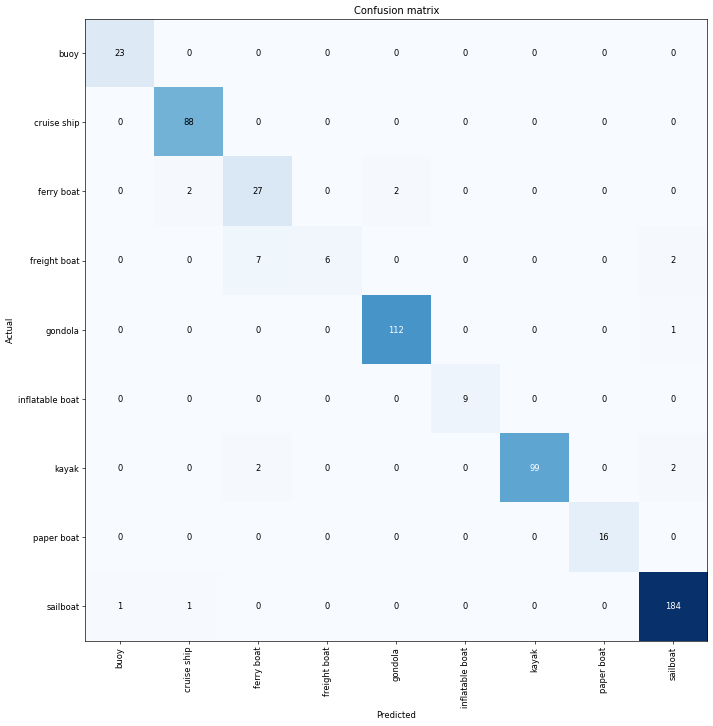

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

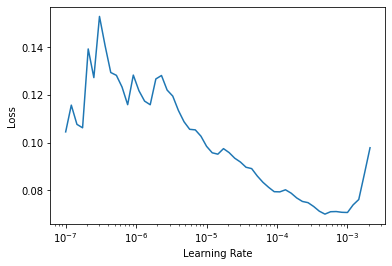

In [ ]:
lr_min,lr_steep = learn.lr_find()

In [ ]:
lr_min

4.786300996784121e-05

In [ ]:
lr_steep

6.309573450380412e-07

In [ ]:
6e-3

0.006

In [ ]:
60e-4

0.006

In [ ]:
10e-3

0.01

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4, 60e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.081766,0.368158,0.095890,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.313825,0.777859,0.152397,01:06
1,0.300994,0.352979,0.089041,01:06
2,0.183981,0.130768,0.027397,01:06
3,0.106787,0.116049,0.027397,01:06


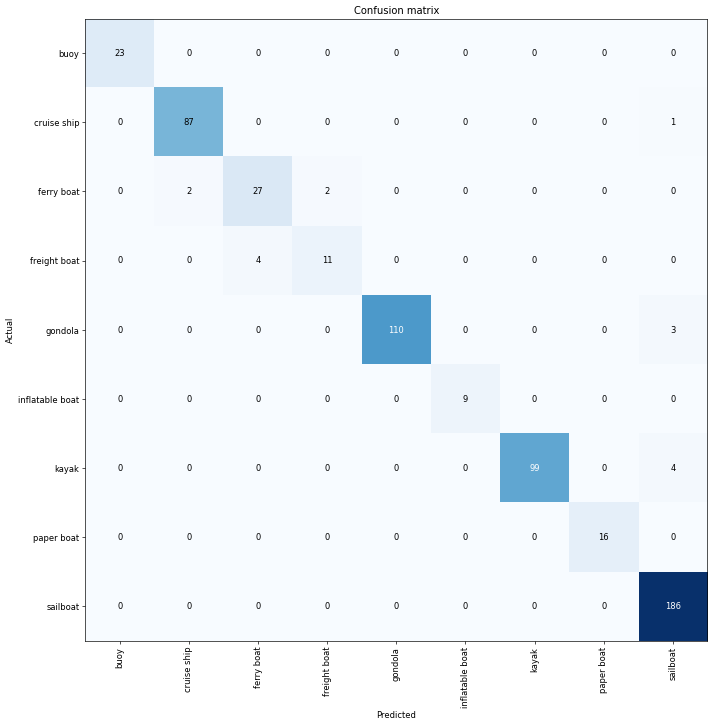

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

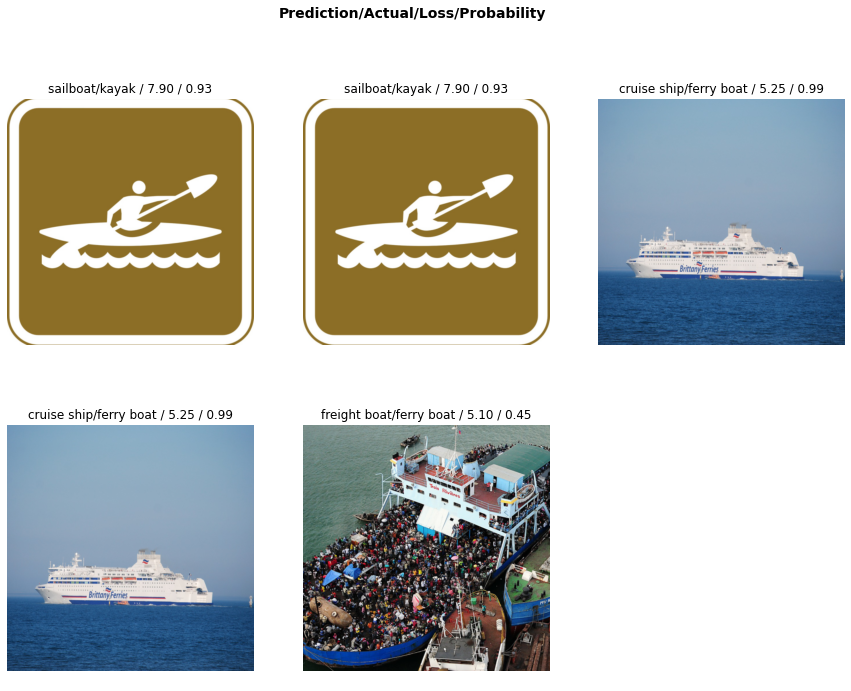

In [ ]:
interp.plot_top_losses(5, figsize=(15,11))